# APS360 Team42 — News Summarization + Image Retrieval → PDF (Full Pipeline)

**Purpose.** This notebook turns a cleaned news CSV into a polished multi-page PDF with **model-generated summaries** and **relevant images**. It uses the Team42 systems built for APS360 (UofT, Summer 2025). The workflow is reproducible, GPU-friendly, and includes quantitative evaluation.

## Configuration used in this notebook (current run)
- **Summarization:** fine-tuned **BART** loaded from `SUMMARIZER_DIR`.
- **Images:** **retrieval (default)** — not T2I.  
  - **Stage-1 recall:** OpenCLIP **ViT-B/32** text→image over a local indexed corpus (512-D).  
  - **Stage-2 rerank:** OpenCLIP **ViT-L/14** to sort candidates.  
  - We keep **3 images per article** using a soft similarity floor + “top-up” (never fewer than 3).
- **PDF build:** one page per article (source preview, summary, images).
- **Evaluation:** ROUGE-L, BERTScore, CLIP alignment, duplicate rate, and word-length stats (article vs. summary).
- *(Optional but disabled here)* **Text-to-Image (T2I)** via Diffusers (`IMAGE_MODEL_DIR`), We didn't use it due to a lack of time.

## Inputs on Drive
- **Data (CSV):** cleaned news dataset  
  **Link:** [Data](https://drive.google.com/drive/folders/1V-gJQl0BDZMAQC83lfIBzE_PoTbXganz?usp=share_link)
- **Models:**  
  - **Summarizer directory (`SUMMARIZER_DIR`)** — fine-tuned BART (e.g., `model.safetensors`, `tokenizer.json`, `config.json`, `generation_config.json`, etc.).  
  - **(Optional) T2I directory (`IMAGE_MODEL_DIR`)** — a Diffusers pipeline for switching to image generation.  
  **Link:** [Models](https://drive.google.com/drive/folders/1ZH-lAjRjBJyNhuIJFsYSwE9kZl_39KRk?usp=share_link)
- **Image Corpus:** `clip_images.rar` (or `.zip`) with JPG/PNG/WEBP.  
  *(Optional)* `clip_image_index.pt` (prebuilt 512-D image features) to skip re-indexing.

## How it works (high level)
1. **Mount & Paths** — set `DATA_CSV_PATH`, `SUMMARIZER_DIR`, `OUTPUTS_DIR` (and optional `IMAGE_MODEL_DIR`).  
2. **Load summarizer** — lead-fusion extract→abstract strategy; safe decoding; terminal punctuation cleanup.  
3. **Retrieve images** — B/32 for first-stage recall (dimension-matched), L/14 for rerank; keep 3 per article.  
4. **Render PDF** — ReportLab layout with header, source preview, summary, and a row of images.  
5. **Evaluate** — print ROUGE-L, BERTScore, CLIP alignment, duplication rate, and article vs. summary lengths; preview one summary + its 3 images.

## Typical results (our final run)
- ROUGE-L ≈ **0.43**, BERTScore ≈ **0.32**, CLIP align ≈ **0.22**.  
- **3 images/article**, summaries ≈ **65 words**, near-zero repetition.  
*(Values vary with dataset/corpus content.)*

## Quick toggles
- `N_ROWS` — how many articles to process.  
- `FINAL_K = 3`, `ALIGN_FLOOR` — images per article and similarity floor for selection.  
- `USE_RETRIEVAL` (default **True**) vs. `USE_T2I` (set **True** only if `IMAGE_MODEL_DIR` is present).  
- Rerank backbone: switch `'ViT-L-14'` ↔ `'ViT-L-14@336px'` for a small CLIP-align bump.

## Repro & notes
- Determinism: `torch.manual_seed(42)` and version printouts are included.  
- Tokenizer name collisions avoided (`sum_tok`/`sum_model` vs. CLIP tokenizers).  
- Dimension safety: first-stage **must** be **ViT-B/32** (512-D) to match `img_feats`; L/14 only for rerank/eval.

## Team & credits
**Team42 — APS360 (Summer 2025), University of Toronto.**  
Built with: Hugging Face Transformers, OpenCLIP, ReportLab, rouge-score, bert-score (and optional Diffusers for T2I).


In [ ]:
# We remove old conflicting installs
!pip uninstall -y numpy scipy scikit-learn

# We install versions that play nicely together
!pip install --upgrade numpy==1.26.4 scipy==1.14.1 scikit-learn==1.5.2

# We reinstall transformers after fixing dependencies
!pip install --upgrade transformers accelerate sentencepiece


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.14.1
Uninstalling scipy-1.14.1:
  Successfully uninstalled scipy-1.14.1
Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.2 MB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
ERROR: pip's dependency resolver does not curr

  Using cached transformers-4.55.2-py3-none-any.whl.metadata (41 kB)
  Using cached sentencepiece-0.2.1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (10 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#All the models and data are saved in our drive
DRIVE_BASE         = "/content/drive/MyDrive"
SUMMARIZER_DIR     = f"{DRIVE_BASE}/model"
IMAGE_MODEL_DIR    = f"{DRIVE_BASE}/image_model"
DATA_CSV_PATH      = f"{DRIVE_BASE}/data/cleaned_dataset.csv"
OUTPUTS_DIR        = f"{DRIVE_BASE}/outputs"

# Create outputs dir if needed
import os
os.makedirs(OUTPUTS_DIR, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Lead-Fusion Extract→Abstract; collision-proof
import re, torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

sum_tok = AutoTokenizer.from_pretrained(SUMMARIZER_DIR, use_fast=True)
sum_model = AutoModelForSeq2SeqLM.from_pretrained(
    SUMMARIZER_DIR,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    low_cpu_mem_usage=True,
).to(device)
sum_model.eval()


TARGET_WORDS     = 72
MIN_WORDS        = 58
MAX_NEW_CAP      = 210   # hard cap in tokens
MIN_NEW_FLOOR    = 80

# sentence utilities
_sent_split = re.compile(r'(?<=[.!?])\s+')
_stop = set("""
a an the and or but if while of in on at by for with without into from to as that this these those is are was were be being been
i you he she it we they them his her their our your its not no yes do did does done have has had will would can could should may might
over under between about after before during around up down out off so than then also just only very more most less least
""".split())

def _words(s): return [w.lower() for w in re.findall(r"[A-Za-z0-9%$€£\-]+", s)]

def _score_sents(sents, lead_bias=1.7):
    # unigram-salience + strong lead bias
    freqs = {}
    for s in sents:
        for w in _words(s):
            if w not in _stop:
                freqs[w] = freqs.get(w, 0) + 1
    scores = []
    for i, s in enumerate(sents):
        sc = sum(freqs.get(w,0) for w in _words(s) if w not in _stop)
        sc *= (lead_bias ** (-i/3.0))
        scores.append(sc)
    return scores

def _lead_fusion(text, lead_k=3, extra_k=2):
    sents = [s.strip() for s in _sent_split.split(text) if s.strip()]
    if len(sents) <= lead_k:
        return " ".join(sents)
    lead = sents[:lead_k]
    rest = sents[lead_k:]
    if not rest:
        return " ".join(lead)
    scores = _score_sents(rest)
    top_idx = sorted(range(len(rest)), key=lambda i: (-scores[i], i))[:extra_k]
    fused = lead + [rest[i] for i in top_idx]
    return " ".join(fused)

# chunking (fallback for very long)
def _chunk_by_tokens(text: str, max_tokens: int, overlap: int = 160):
    ids = sum_tok.encode(text, add_special_tokens=False)
    if len(ids) <= max_tokens: return [text]
    chunks, i = [], 0
    while i < len(ids):
        window = ids[i:i+max_tokens]
        chunks.append(sum_tok.decode(window, skip_special_tokens=True))
        if i + max_tokens >= len(ids): break
        i += max_tokens - overlap
    return chunks

# decoding tuned for faithfulness (less paraphrase)
GEN_KW = dict(
    do_sample=False,
    num_beams=4,
    length_penalty=1.00,
    no_repeat_ngram_size=3,
    repetition_penalty=1.00,
    early_stopping=True,
)

def _gen(texts, max_new=180, min_new=90):
    inputs = sum_tok(texts, truncation=True, max_length=1024, return_tensors="pt", padding=True).to(device)
    with torch.inference_mode():
        out = sum_model.generate(
            **inputs,
            max_new_tokens=max_new,
            min_new_tokens=min_new,
            **GEN_KW
        )
    return sum_tok.batch_decode(out, skip_special_tokens=True)

# length targeting around word counts
def _token_targets_for_words(target_words):
    # crude token estimate: ~1.3–1.6x words for encoder-decoder
    return int(target_words * 1.5)

def _length_targets(texts):
    # fixed band for stability across articles
    max_new = min(MAX_NEW_CAP, _token_targets_for_words(TARGET_WORDS))
    min_new = max(MIN_NEW_FLOOR, _token_targets_for_words(MIN_WORDS))
    return max_new, min_new

# cleaner + terminal punctuation
def _clean_summary(s: str):
    s = " ".join(s.split()).replace(" .", ".").replace(" ,", ",")
    parts = [p.strip() for p in _sent_split.split(s) if p.strip()]
    # de-dup near-identical sentences
    out, seen = [], set()
    for p in parts:
        key = re.sub(r'\W+', '', p.lower())
        if key and key not in seen:
            seen.add(key); out.append(p)
    s = " ".join(out)
    if s and s[0].islower(): s = s[0].upper() + s[1:]
    if s and not s.endswith(('.', '!', '?')): s += '.'
    return s

# summarize (short sources)
def summarize_batch(texts):
    fused = [_lead_fusion(t, lead_k=3, extra_k=2) for t in texts]
    max_new, min_new = _length_targets(fused)
    return [_clean_summary(s) for s in _gen(fused, max_new=max_new, min_new=min_new)]

#ummarize (long sources)
def summarize_long(text: str, chunk_max_tokens=960, chunk_overlap=160):
    base = _lead_fusion(text, lead_k=3, extra_k=3)
    chunks = _chunk_by_tokens(base, max_tokens=chunk_max_tokens, overlap=chunk_overlap)
    if len(chunks) == 1:
        return summarize_batch([chunks[0]])[0]
    first = _gen(chunks, max_new=120, min_new=70)
    merged = " ".join(first)
    max_new, min_new = _length_targets([merged])
    return _clean_summary(_gen([merged], max_new=max_new, min_new=min_new)[0])

# public API
def summarize_any(texts_or_series):
    out = []
    for t in texts_or_series:
        t = str(t or "").strip()
        if not t: out.append(""); continue
        n_tok = len(sum_tok.encode(t, add_special_tokens=False))
        out.append(summarize_batch([t])[0] if n_tok <= 1200 else summarize_long(t))
    return out


/usr/local/lib/python3.11/dist-packages/transformers/models/bart/configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


In [ ]:
from transformers import AutoConfig
import torch, os

print("Model path:", sum_model.name_or_path)
print("Tokenizer path:", getattr(sum_tok, "name_or_path", "<unknown>"))
print("Device:", next(sum_model.parameters()).device)
print("Param count (M):", round(sum(p.numel() for p in sum_model.parameters())/1e6, 2))

cfg = AutoConfig.from_pretrained(SUMMARIZER_DIR)
print("Config model_type:", cfg.model_type)
print("Local dir exists:", os.path.isdir(SUMMARIZER_DIR))


Model path: /content/drive/MyDrive/model
Tokenizer path: /content/drive/MyDrive/model
Device: cuda:0
Param count (M): 305.51
Config model_type: bart
Local dir exists: True


/usr/local/lib/python3.11/dist-packages/transformers/models/bart/configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


In [ ]:
# --- Block 5: Retrieval-only (disable T2I explicitly) ---
import torch, os

# Robust device flag
_device = next(sum_model.parameters()).device
is_cuda = (_device.type == "cuda") and torch.cuda.is_available()

# We are NOT using text-to-image in this run
USE_T2I = False
t2i_pipe = None
print("Text-to-Image disabled; using OpenCLIP retrieval only.")

# (Optional) sanity: enforce flags other blocks may read
USE_RETRIEVAL = True


Text-to-Image disabled; using OpenCLIP retrieval only.


In [ ]:
# --- Retrieval fallback: robust + VRAM-safe index build/load ---
!pip -q install "open_clip_torch==2.26.1" ftfy regex tqdm rarfile

import os, glob, subprocess, zipfile, rarfile, torch
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import open_clip

# Reduce CUDA fragmentation (optional but helpful)
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "max_split_size_mb:128")

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) Locate archive on Drive
DRIVE_BASE = "/content/drive/MyDrive"
candidates = glob.glob(f"{DRIVE_BASE}/**/clip_images.rar", recursive=True) + \
             glob.glob(f"{DRIVE_BASE}/**/clip_images.zip", recursive=True)
if not candidates:
    raise FileNotFoundError("Could not find clip_images.rar (or .zip) anywhere under My Drive.")
ARCHIVE_PATH = candidates[0]
print("Found archive:", ARCHIVE_PATH)

# 2) Extract to /content/clip_images
EXTRACT_DIR = Path("/content/clip_images")
if not EXTRACT_DIR.exists() or not any(EXTRACT_DIR.rglob("*")):
    EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
    if ARCHIVE_PATH.lower().endswith(".rar"):
        try:
            with rarfile.RarFile(ARCHIVE_PATH) as rf:
                rf.extractall(EXTRACT_DIR.as_posix())
        except rarfile.RarCannotExec:
            subprocess.run(["apt-get","update","-y"], check=True)
            subprocess.run(["apt-get","install","-y","unrar"], check=True)
            subprocess.run(["unrar","x","-o+", ARCHIVE_PATH, EXTRACT_DIR.as_posix()], check=True)
    else:
        with zipfile.ZipFile(ARCHIVE_PATH) as zf:
            zf.extractall(EXTRACT_DIR.as_posix())

# 3) Collect valid images (skip corrupt)
patterns = ["**/*.jpg","**/*.jpeg","**/*.png","**/*.webp","**/*.JPG","**/*.JPEG","**/*.PNG","**/*.WEBP"]
raw_paths = []
for pat in patterns:
    raw_paths.extend(glob.glob(str(EXTRACT_DIR / pat), recursive=True))

image_paths = []
for p in raw_paths:
    try:
        with Image.open(p) as im:
            im.verify()
        image_paths.append(p)
    except (UnidentifiedImageError, OSError):
        pass

if not image_paths:
    raise FileNotFoundError("No valid jpg/png/webp found in /content/clip_images after extraction.")
print(f"Images found (valid): {len(image_paths)}")

# 4) Build or load index (CPU tensors for portability/safety)
INDEX_OUT = "/content/clip_image_index.pt"
img_feats = None

if os.path.exists(INDEX_OUT):
    blob = torch.load(INDEX_OUT, map_location="cpu")  # load to CPU first
    if isinstance(blob, dict) and "feats" in blob and "paths" in blob and len(blob["paths"]) == len(image_paths):
        img_feats = blob["feats"]           # CPU
        image_paths = blob["paths"]
        print("Loaded existing index:", INDEX_OUT, "| Feats shape:", tuple(img_feats.shape))
    else:
        print("Index mismatch → rebuilding …")
        os.remove(INDEX_OUT)

if img_feats is None:
    # Use quick-gelu variant to match 'openai' tag (removes QuickGELU warning)
    model_name = "ViT-B-32-quickgelu"
    clip_model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained="openai")
    clip_model.eval().to(device)

    # Batch size by VRAM
    if device == "cuda":
        total_mem = torch.cuda.get_device_properties(0).total_memory
        batch = 64 if total_mem >= 20_000_000_000 else 32
    else:
        batch = 16

    feats = []
    with torch.inference_mode():
        for i in range(0, len(image_paths), batch):
            batch_paths = image_paths[i:i+batch]
            ims = []
            for p in batch_paths:
                try:
                    ims.append(preprocess(Image.open(p).convert("RGB")))
                except Exception:
                    # skip late failures
                    continue
            if not ims:
                continue
            ims = torch.stack(ims).to(device, non_blocking=True)

            # fp16 on CUDA to cut VRAM
            if device == "cuda":
                with torch.cuda.amp.autocast(dtype=torch.float16):
                    f = clip_model.encode_image(ims)
            else:
                f = clip_model.encode_image(ims)

            feats.append(f.detach().float().cpu())  # move to CPU immediately
            del ims, f
            if device == "cuda":
                torch.cuda.empty_cache()

    img_feats = torch.cat(feats, dim=0)  # CPU tensor
    img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
    torch.save({"feats": img_feats, "paths": image_paths}, INDEX_OUT)
    print("Built index:", INDEX_OUT, "| Feats shape:", tuple(img_feats.shape))

# Keep a GPU copy for fast retrieval if available
img_feats = img_feats.to(device, non_blocking=True)

USE_T2I = False
USE_RETRIEVAL = True

# 5) Retrieval function (text -> topk image paths)
def retrieve_images(prompts, topk=2):
    # Ensure a matching text encoder is present
    if 'clip_model' not in globals():
        clip_model_local, _, _ = open_clip.create_model_and_transforms("ViT-B-32-quickgelu", pretrained="openai")
        clip_model_local.eval().to(device)
    else:
        clip_model_local = clip_model

    tok = open_clip.get_tokenizer("ViT-B-32-quickgelu")
    out = []
    with torch.inference_mode():
        tokens = tok(prompts)
        if isinstance(tokens, dict):
            tokens = {k: v.to(device) for k, v in tokens.items()}
        else:
            tokens = tokens.to(device)
        if device == "cuda":
            with torch.cuda.amp.autocast(dtype=torch.float16):
                tfeat = clip_model_local.encode_text(tokens)
        else:
            tfeat = clip_model_local.encode_text(tokens)
        tfeat = tfeat / tfeat.norm(dim=-1, keepdim=True)
        sims = tfeat @ img_feats.T
        for row in sims:
            idx = row.topk(topk).indices.tolist()
            out.append([image_paths[i] for i in idx])
    return out

print("Retrieval index ready. USE_RETRIEVAL =", USE_RETRIEVAL, "| USE_T2I =", USE_T2I)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 62.3 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Found archive: /content/drive/MyDrive/Indy/APS360/APS360 Team42/Image Retrieval Pipeline/clip_images.rar
Images found (valid): 4439


100%|███████████████████████████████████████| 354M/354M [00:13<00:00, 26.0MiB/s]
/tmp/ipython-input-423576543.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


Built index: /content/clip_image_index.pt | Feats shape: (4439, 512)
Retrieval index ready. USE_RETRIEVAL = True | USE_T2I = False


In [ ]:
print("USE_T2I =", USE_T2I, "| USE_RETRIEVAL =", USE_RETRIEVAL, "| images:", (len(image_paths) if USE_RETRIEVAL else '—'))


USE_T2I = False | USE_RETRIEVAL = True | images: 4439


In [ ]:
# dataset → summaries → images (3 per summary; B/32 retrieve + L/14 rerank)
import pandas as pd, re, numpy as np, os, torch, open_clip
from tqdm import tqdm
from PIL import Image

# data
df = pd.read_csv(DATA_CSV_PATH)
name_map = {c.lower(): c for c in df.columns}
TEXT_COL = (name_map.get("content") or name_map.get("text") or name_map.get("article") or
            name_map.get("body") or name_map.get("document") or name_map.get("story"))
if not TEXT_COL:
    raise ValueError(f"No obvious text column found. Columns: {list(df.columns)}")

N_ROWS = 30
rows = df[df[TEXT_COL].astype(str).str.strip().ne("")].head(N_ROWS if N_ROWS else len(df)).reset_index(drop=True)

device = "cuda" if torch.cuda.is_available() else "cpu"


assert 'img_feats' in globals() and 'image_paths' in globals(), "Run Block 4B first to build img_feats/image_paths."
img_feats = img_feats.to(device).float()


# Summaries (uses Block 3: summarize_any with sum_tok/sum_model)

all_summaries = []
BATCH = 8
for i in tqdm(range(0, len(rows), BATCH), desc="Summarizing"):
    batch_texts = rows.loc[i:i+BATCH-1, TEXT_COL].astype(str).tolist()
    all_summaries.extend(summarize_any(batch_texts))


# Images (3 per item): B/32 first-stage retrieval → L/14 rerank → soft floor + top-up

FINAL_K     = 3
ALIGN_FLOOR = 0.22
RETR_TOPK   = 12

def img_query(summary: str):
    # Hybrid: entities/numbers + full context
    keys = re.findall(r'\b([A-Z][a-zA-Z]{2,}|[A-Z]{2,5}|\d{4}|USD|EUR|%|[A-Z][a-z]+(?:\s[A-Z][a-z]+)?)\b', summary)
    key_str = " ".join(dict.fromkeys(keys))
    return (summary + " " + key_str).strip()

def retrieve_images_b32(prompts, topk=RETR_TOPK):
    """First-stage retrieval with ViT-B/32 (matches 512-D img_feats)."""
    enc_model, _, _ = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
    enc_model = enc_model.to(device).eval()
    enc_tok = open_clip.get_tokenizer('ViT-B-32')
    out = []
    with torch.inference_mode():
        tokens = enc_tok(prompts)
        tokens = {k:v.to(device) for k,v in tokens.items()} if isinstance(tokens, dict) else tokens.to(device)
        tfeat = enc_model.encode_text(tokens)
        tfeat = (tfeat / tfeat.norm(dim=-1, keepdim=True)).float()         # [N,512]
        sims = tfeat @ img_feats.T                                         # [N,M]
        for row in sims:
            idx = row.topk(topk).indices.tolist()
            out.append([image_paths[i] for i in idx])
    return out  # list[list[path]]

all_images = []

if USE_T2I:
    def make_image_prompts(summary: str):
        return [f"Editorial photo illustrating: {summary}. Global news, realistic, clean composition, 3:2."]
    for s in tqdm(all_summaries, desc="Generating images"):
        ims = generate_images(make_image_prompts(s), num_images=FINAL_K)
        all_images.append(ims)  # list[PIL.Image]

elif USE_RETRIEVAL:
    # 1) First-stage retrieval (B/32)
    queries = [img_query(s) for s in all_summaries]
    first_stage = retrieve_images_b32(queries)  # list[list[path]]

    # 2) Rerank with ViT-L/14 (stronger), apply soft floor, always top-up to FINAL_K
    clipL, _, preprocessL = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')
    clipL = clipL.to(device).eval()
    tokL = open_clip.get_tokenizer('ViT-L-14')

    def enc_text_L(txts):
        with torch.inference_mode():
            tks = tokL(txts)
            tks = {k:v.to(device) for k,v in tks.items()} if isinstance(tks, dict) else tks.to(device)
            t = clipL.encode_text(tks)
            return (t / t.norm(dim=-1, keepdim=True)).float()

    def enc_imgs_L(paths):
        feats, batch = [], 16
        with torch.inference_mode():
            for i in range(0, len(paths), batch):
                ims = []
                for p in paths[i:i+batch]:
                    try: ims.append(preprocessL(Image.open(p).convert("RGB")))
                    except: ims.append(preprocessL(Image.new("RGB",(224,224),(0,0,0))))
                x = torch.stack(ims).to(device)
                feats.append(clipL.encode_image(x))
        v = torch.cat(feats, dim=0)
        return (v / v.norm(dim=-1, keepdim=True)).float()

    text_feats = enc_text_L(all_summaries)

    flat_paths = [p for paths in first_stage for p in paths]
    uniq_paths = list(dict.fromkeys(flat_paths))
    path_to_idx = {p:i for i,p in enumerate(uniq_paths)}
    uniq_feats = enc_imgs_L(uniq_paths)

    for i, paths in enumerate(first_stage):
        paths = [p for p in paths if isinstance(p, str) and os.path.exists(p)]
        if not paths:
            all_images.append([])
            continue
        idxs = [path_to_idx[p] for p in paths]
        v = uniq_feats[idxs]                           # k x d
        t = text_feats[i:i+1]                          # 1 x d
        sims = (t @ v.T).squeeze(0).cpu().numpy()      # k
        order = sims.argsort()[::-1]

        picked = [paths[j] for j in order if sims[j] >= ALIGN_FLOOR][:FINAL_K]
        if len(picked) < FINAL_K:                      # top-up to 3 regardless
            used = set(picked)
            for j in order:
                if paths[j] not in used:
                    picked.append(paths[j]); used.add(paths[j])
                if len(picked) == FINAL_K: break
        if not picked and paths:                       # extreme safety
            picked = [paths[order[0]]]

        all_images.append(picked)

else:
    all_images = [[] for _ in all_summaries]

assert len(all_summaries) == len(rows) == len(all_images)
print("Block 5 done:", len(all_summaries), "items; images/item =", np.mean([len(x) for x in all_images]))
print("sample paths for item 0:", (all_images[0] if all_images else []))


Summarizing: 100%|██████████| 4/4 [00:24<00:00,  6.08s/it]
100%|████████████████████████████████████████| 933M/933M [00:07<00:00, 117MiB/s]


Block 5 done: 30 items; images/item = 3.0
sample paths for item 0: ['/content/clip_images/clip_images/wholesaler.jpg', '/content/clip_images/clip_images/carrier.jpg', '/content/clip_images/clip_images/food.jpg']


In [ ]:
import os, numpy as np
cnts = [len(x) for x in all_images]
exist_ok = [[p for p in x if isinstance(p, str) and os.path.exists(p)] for x in all_images]
print("images/item (mean):", np.mean(cnts), "min:", min(cnts), "max:", max(cnts))
print("missing files per item (first 5):", [len(x)-len(y) for x,y in zip(all_images, exist_ok)][:5])
print("sample paths for item 0:", all_images[0] if all_images else [])


images/item (mean): 3.0 min: 3 max: 3
missing files per item (first 5): [0, 0, 0, 0, 0]
sample paths for item 0: ['/content/clip_images/clip_images/wholesaler.jpg', '/content/clip_images/clip_images/carrier.jpg', '/content/clip_images/clip_images/food.jpg']


In [ ]:
pip install -U reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.8 MB/s eta 0:00:00


In [ ]:
#Polished PDF builder
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.units import cm
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import Paragraph
from reportlab.lib.enums import TA_LEFT
from reportlab.lib import utils
from textwrap import shorten
from PIL import Image, UnidentifiedImageError
import os

PAGE_W, PAGE_H = A4
MARGIN = 1.2*cm
CONTENT_W = PAGE_W - 2*MARGIN

def _wrap_paragraph(text, font_size=11, leading=14):
    styles = getSampleStyleSheet()
    st = styles["Normal"]
    st.fontName = "Helvetica"
    st.fontSize = font_size
    st.leading = leading
    st.alignment = TA_LEFT
    return Paragraph(text.replace("\n"," ").strip(), st)

def _draw_paragraph(c, p: Paragraph, x, y, max_w):
    w, h = p.wrap(max_w, PAGE_H)
    p.drawOn(c, x, y - h)
    return h

def _pil_to_tmp(img: Image.Image, max_w_px=1600):
    ratio = min(1.0, max_w_px / max(img.size))
    if ratio < 1.0:
        img = img.resize((int(img.width*ratio), int(img.height*ratio)), Image.LANCZOS)
    path = f"/content/_tmp_{id(img)}.jpg"
    img.save(path, "JPEG", quality=88, optimize=True)
    return path

def _draw_image_row_pils(c, imgs, x, y, max_w, height=7*cm, gap=0.5*cm):
    # imgs: list[PIL.Image]
    imgs = imgs[:3]
    if not imgs: return 0
    cols = len(imgs)
    cell_w = (max_w - (cols-1)*gap)/cols
    max_h = 0
    for ci, im in enumerate(imgs):
        path = _pil_to_tmp(im)
        iw, ih = utils.ImageReader(path).getSize()
        scale = min(cell_w/iw, height/ih)
        w, h = iw*scale, ih*scale
        xi = x + ci*(cell_w+gap) + (cell_w - w)/2
        yi = y - h
        c.drawImage(path, xi, yi, width=w, height=h)
        max_h = max(max_h, h)
    return max_h

def _draw_image_row_paths(c, paths, x, y, max_w, height=7*cm, gap=0.5*cm):
    # paths: list[str]
    paths = [p for p in paths if isinstance(p, str) and os.path.exists(p)]
    paths = paths[:3]
    if not paths: return 0
    cols = len(paths)
    cell_w = (max_w - (cols-1)*gap)/cols
    max_h = 0
    for ci, p in enumerate(paths):
        try:
            iw, ih = utils.ImageReader(p).getSize()
        except Exception:
            # Try reopen/convert via PIL as fallback
            try:
                im = Image.open(p).convert("RGB")
                p = _pil_to_tmp(im)
                iw, ih = utils.ImageReader(p).getSize()
            except (UnidentifiedImageError, FileNotFoundError):
                continue
        scale = min(cell_w/iw, height/ih)
        w, h = iw*scale, ih*scale
        xi = x + ci*(cell_w+gap) + (cell_w - w)/2
        yi = y - h
        c.drawImage(p, xi, yi, width=w, height=h)
        max_h = max(max_h, h)
    return max_h

def _footer(c, idx):
    c.setFont("Helvetica", 9)
    c.drawRightString(PAGE_W - MARGIN, 0.8*cm, f"Page {idx}")

def build_pdf(sources, summaries, images_per_item, out_path):
    c = canvas.Canvas(out_path, pagesize=A4)
    for idx, (src, summ, imgs) in enumerate(zip(sources, summaries, images_per_item), 1):
        c.setTitle("Automated News Summary & Images")
        c.setAuthor("Your Pipeline")

        # Header
        c.setFont("Helvetica-Bold", 15)
        c.drawString(MARGIN, PAGE_H - MARGIN, f"News Summary {idx}")

        # Source (truncated preview)
        preview = shorten(str(src), width=600, placeholder="...")
        p1 = _wrap_paragraph(f"<b>Source (preview):</b> {preview}", font_size=10, leading=13)
        top_y = PAGE_H - MARGIN - 1.0*cm
        h1 = _draw_paragraph(c, p1, MARGIN, top_y, CONTENT_W)

        # Summary
        p2 = _wrap_paragraph(f"<b>Model Summary:</b> {summ}", font_size=12, leading=16)
        h2 = _draw_paragraph(c, p2, MARGIN, top_y - h1 - 0.6*cm, CONTENT_W)

        # Images
        y_start = top_y - h1 - h2 - 1.0*cm
        if isinstance(imgs, list) and imgs:
            if isinstance(imgs[0], Image.Image):
                _draw_image_row_pils(c, imgs, MARGIN, y_start, CONTENT_W, height=7*cm)
            elif isinstance(imgs[0], str):
                _draw_image_row_paths(c, imgs, MARGIN, y_start, CONTENT_W, height=7*cm)

        _footer(c, idx)
        c.showPage()
    c.save()

# Build the PDF
SRC_PREV_COL = TEXT_COL
pdf_path = "/content/News_Summary_Deck.pdf"
build_pdf(rows[SRC_PREV_COL].tolist(), all_summaries, all_images, pdf_path)

# Copy to Drive
import shutil, os
os.makedirs(OUTPUTS_DIR, exist_ok=True)
final_path = f"{OUTPUTS_DIR}/News_Summary_Deck.pdf"
shutil.copy(pdf_path, final_path)
print("Saved:", final_path)


Saved: /content/drive/MyDrive/outputs/News_Summary_Deck.pdf


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 28.1 MB/s eta 0:00:00
Evaluating 30 summaries with images.

Length (words)
articles   : 692.8 ± 585.2 (median 556.0)
summaries  : 65.6 ± 5.5 (median 66.0)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Summary metrics (mean ± sd)
rougeL      : 0.429 ± 0.148
bertscore   : 0.319 ± 0.164
len_words   : 65.567 ± 5.600
rep_trigram : 0.000 ± 0.000

Image metrics (mean ± sd)
clip_align    : 0.231 ± 0.025
dup_rate      : 0.000 ± 0.000
images_per_item: 3.000 ± 0.000

=== Sample item #28 ===
Article length (words): 337
Summary length (words): 70

SUMMARY:
 Rupee closes at 75.59 against the dollar, down 70 paise from its previous close. rupee has been under pressure on back of selling by fiis in equity and debt segment. number of covid-19 cases climbed to 1,071 in india on monday. death toll from the new coronavirus has touched nearly 35,000. global crude oil benchmark brent falls 8.34 per cent to usd 22.85 per barrel amid concerns over global growth.


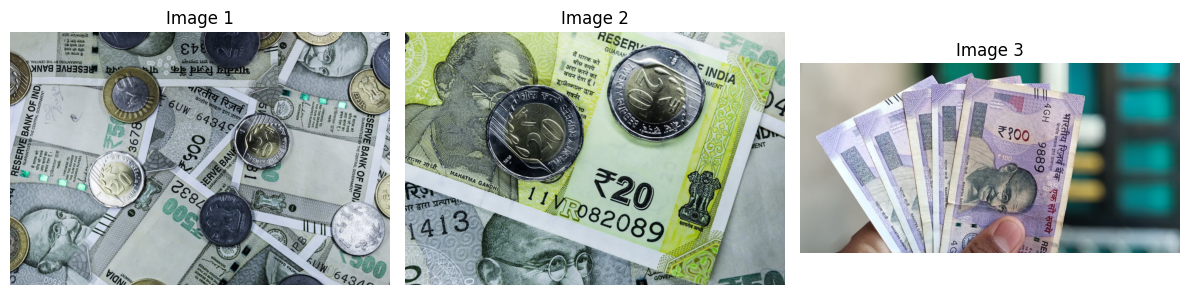

In [ ]:

# Summary & Image Evaluation (ViT-L-14 matched to rerank) + Article length + Sample preview

!pip -q install rouge-score bert-score open_clip_torch ftfy regex tqdm imagehash pillow matplotlib

import torch, numpy as np, pandas as pd
from rouge_score import rouge_scorer
import bert_score
import open_clip
from PIL import Image
import imagehash, os
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


# Prepare inputs

sources = rows[TEXT_COL].astype(str).tolist()
summaries = list(map(str, all_summaries))

# Normalize images to paths
normalized_images = []
for item in all_images:
    if len(item) == 0:
        normalized_images.append([])
    elif isinstance(item[0], Image.Image):  # Generated images
        tmp_paths = []
        for im in item:
            p = f"/content/_eval_{id(im)}.jpg"
            im.save(p, "JPEG", quality=90)
            tmp_paths.append(p)
        normalized_images.append(tmp_paths)
    else:  # Retrieval (paths)
        normalized_images.append([str(p) for p in item])

print(f"Evaluating {len(sources)} summaries with images.")


# 0) Article vs Summary Length

src_len_words = [len(s.split()) for s in sources]
sum_len_words = [len(s.split()) for s in summaries]

print("\nLength (words)")
print(f"articles   : {np.mean(src_len_words):.1f} ± {np.std(src_len_words):.1f} (median {np.median(src_len_words):.1f})")
print(f"summaries  : {np.mean(sum_len_words):.1f} ± {np.std(sum_len_words):.1f} (median {np.median(sum_len_words):.1f})")


# 1) Summary Quality

def first_k_sentences(text, k=4):
    s = text.replace("\n", " ")
    parts = [p.strip() for p in s.split('.') if p.strip()]
    return '. '.join(parts[:k]) + ('.' if parts[:k] else '')

refs = [first_k_sentences(s) for s in sources]
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rougeL = [scorer.score(r, h)['rougeL'].fmeasure for r, h in zip(refs, summaries)]

P, R, F1 = bert_score.score(cands=summaries, refs=refs, lang='en', rescale_with_baseline=True)
berts = F1.tolist()

def repetition_ratio(s: str, ngram=3):
    toks = s.lower().split()
    if len(toks) < ngram: return 0.0
    ngrams = [' '.join(toks[i:i+ngram]) for i in range(len(toks)-ngram+1)]
    return 1 - (len(set(ngrams)) / len(ngrams))

rep3 = [repetition_ratio(s, 3) for s in summaries]

summary_df = pd.DataFrame({
    "rougeL": rougeL,
    "bertscore": berts,
    "len_words": sum_len_words,
    "rep_trigram": rep3
})

print("\nSummary metrics (mean ± sd)")
for col in ["rougeL", "bertscore", "len_words", "rep_trigram"]:
    print(f"{col:12s}: {summary_df[col].mean():.3f} ± {summary_df[col].std():.3f}")


# 2) Image Alignment & Diversity (ViT-L-14)

clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')
clip_model = clip_model.to(device)
tok = open_clip.get_tokenizer('ViT-L-14')

def clip_text_feats(texts):
    with torch.inference_mode():
        tokens = tok(texts)
        tokens = {k:v.to(device) for k,v in tokens.items()} if isinstance(tokens, dict) else tokens.to(device)
        t = clip_model.encode_text(tokens)
        return (t / t.norm(dim=-1, keepdim=True)).float()

def clip_img_feats(paths):
    batch, feats = 16, []
    with torch.inference_mode():
        for i in range(0, len(paths), batch):
            ims = []
            for p in paths[i:i+batch]:
                try:
                    im = Image.open(p).convert("RGB")
                    ims.append(preprocess(im))
                except Exception:
                    ims.append(preprocess(Image.new("RGB", (224, 224), (0, 0, 0))))
            ims = torch.stack(ims).to(device)
            feats.append(clip_model.encode_image(ims))
    f = torch.cat(feats, dim=0)
    return (f / f.norm(dim=-1, keepdim=True)).float()

text_feats = clip_text_feats(summaries)

align_scores = []
dup_rates = []
all_img_paths = [p for paths in normalized_images for p in paths]

if len(all_img_paths) == 0:
    print("\nNo images to evaluate.")
else:
    # Precompute all image embeddings
    img_offsets = []
    cur = 0
    for paths in normalized_images:
        img_offsets.append((cur, cur+len(paths)))
        cur += len(paths)
    all_img_feats = clip_img_feats(all_img_paths)

    for i, paths in enumerate(normalized_images):
        start, end = img_offsets[i]
        if start == end:
            align_scores.append(np.nan)
            dup_rates.append(np.nan)
            continue

        t = text_feats[i:i+1]
        v = all_img_feats[start:end]
        sim = (t @ v.T).squeeze(0).cpu().numpy()
        align_scores.append(float(sim.max()))

        # Duplicate rate
        hashes = [imagehash.phash(Image.open(p).convert("RGB")) for p in paths]
        pairs = 0
        dups = 0
        for a in range(len(hashes)):
            for b in range(a+1, len(hashes)):
                pairs += 1
                if abs(hashes[a] - hashes[b]) <= 4:
                    dups += 1
        dup_rates.append(dups / pairs if pairs else 0.0)

    image_df = pd.DataFrame({
        "clip_align": align_scores,
        "dup_rate": dup_rates,
        "images_per_item": [len(p) for p in normalized_images]
    })

    print("\nImage metrics (mean ± sd)")
    for col in ["clip_align", "dup_rate", "images_per_item"]:
        print(f"{col:14s}: {image_df[col].mean():.3f} ± {image_df[col].std():.3f}")


# 3) Show one example summary + its 3 images

if len(all_img_paths) > 0 and len(align_scores) == len(normalized_images):
    try:
        sample_idx = int(np.nanargmax(align_scores))
    except ValueError:
        sample_idx = next((i for i, lst in enumerate(normalized_images) if len(lst) > 0), 0)
else:
    sample_idx = next((i for i, lst in enumerate(normalized_images) if len(lst) > 0), 0)

print(f"\n=== Sample item #{sample_idx} ===")
print(f"Article length (words): {src_len_words[sample_idx]}")
print(f"Summary length (words): {sum_len_words[sample_idx]}")
print("\nSUMMARY:\n", summaries[sample_idx])

paths = normalized_images[sample_idx][:3]
paths = [p for p in paths if isinstance(p, str) and os.path.exists(p)]
if paths:
    n = len(paths)
    plt.figure(figsize=(4*n, 3))
    for i, p in enumerate(paths, 1):
        try:
            im = Image.open(p).convert("RGB")
        except Exception:
            im = Image.new("RGB", (224,224), (0,0,0))
        ax = plt.subplot(1, n, i)
        ax.imshow(im)
        ax.set_title(f"Image {i}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No images found on disk for this item.")


In [ ]:
from google.colab import files
import pandas as pd

# Upload the CSV
uploaded = files.upload()
csv_filename = list(uploaded.keys())[0]  # Get uploaded file name

# Read the CSV into a DataFrame
df_new = pd.read_csv(csv_filename)

print(f"Loaded {len(df_new)} rows from {csv_filename}")
print("Columns:", df_new.columns.tolist())


Saving new_test_data.csv to new_test_data.csv
Loaded 5 rows from new_test_data.csv
Columns: ['url', 'title', 'text', 'summary']


In [ ]:
# --- Reset and prepare summaries+images for new_test_data.csv ---
import re, os, torch, open_clip
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np

assert 'sum_model' in globals() and 'sum_tok' in globals(), "Load your fine-tuned summarizer first (Block 3)."
assert 'img_feats' in globals() and 'image_paths' in globals(), "Build the retrieval index first (Block 6)."

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load new CSV and pick the text column
DATA_CSV_PATH = "new_test_data.csv"
df = pd.read_csv(DATA_CSV_PATH)
name_map = {c.lower(): c for c in df.columns}
TEXT_COL = (name_map.get("text") or name_map.get("content") or name_map.get("article")
            or name_map.get("body") or name_map.get("document") or name_map.get("story"))
assert TEXT_COL, f"No obvious text column found. Columns: {list(df.columns)}"

rows = df[df[TEXT_COL].astype(str).str.strip().ne("")].reset_index(drop=True)
print("Rows to process:", len(rows))

# Summarize (uses your fine-tuned model)
def summarize_fn(batch_texts, max_new_tokens=180, min_new_tokens=40):
    tok = sum_tok
    model = sum_model
    outs = []
    for txt in batch_texts:
        inputs = tok(txt, return_tensors="pt", truncation=True, max_length=1024).to(model.device)
        gen = model.generate(
            **inputs,
            do_sample=False,
            num_beams=4,
            length_penalty=1.0,
            max_new_tokens=max_new_tokens,
            min_new_tokens=min_new_tokens,
            no_repeat_ngram_size=3,
            eos_token_id=tok.eos_token_id,
        )
        outs.append(tok.decode(gen[0], skip_special_tokens=True).strip())
    return outs

BATCH = 8
all_summaries = []
for i in tqdm(range(0, len(rows), BATCH), desc="Summarizing (new CSV)"):
    batch = rows.loc[i:i+BATCH-1, TEXT_COL].astype(str).tolist()
    all_summaries.extend(summarize_fn(batch))

assert len(all_summaries) == len(rows), "Summaries length mismatch."
print("Summaries ready:", len(all_summaries))

# Retrieval: B/32 quickgelu recall → L/14 rerank (matches index and eval)
img_feats = img_feats.to(device).float()

def img_query(summary: str):
    keys = re.findall(r'\b([A-Z][a-zA-Z]{2,}|[A-Z]{2,5}|\d{4}|USD|EUR|%|[A-Z][a-z]+(?:\s[A-Z][a-z]+)?)\b', summary)
    key_str = " ".join(dict.fromkeys(keys))
    return (summary + " " + key_str).strip()

RETR_TOPK   = 12
FINAL_K     = 3
ALIGN_FLOOR = 0.22

def retrieve_images_b32(prompts, topk=RETR_TOPK):
    model_name = 'ViT-B-32-quickgelu'
    enc_model, _, _ = open_clip.create_model_and_transforms(model_name, pretrained='openai')
    enc_model = enc_model.to(device).eval()
    enc_tok = open_clip.get_tokenizer(model_name)
    out = []
    with torch.inference_mode():
        tokens = enc_tok(prompts)
        tokens = {k:v.to(device) for k,v in tokens.items()} if isinstance(tokens, dict) else tokens.to(device)
        if device == "cuda":
            with torch.amp.autocast('cuda', dtype=torch.float16):
                tfeat = enc_model.encode_text(tokens)
        else:
            tfeat = enc_model.encode_text(tokens)
        tfeat = (tfeat / tfeat.norm(dim=-1, keepdim=True)).float()
        sims = tfeat @ img_feats.T
        for row in sims:
            idx = row.topk(topk).indices.tolist()
            out.append([image_paths[i] for i in idx])
    return out

# First-stage recall
queries = [img_query(s) for s in all_summaries]
first_stage = retrieve_images_b32(queries)

# Rerank with ViT-L/14
clipL, _, preprocessL = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')
clipL = clipL.to(device).eval()
tokL = open_clip.get_tokenizer('ViT-L-14')

def enc_text_L(txts):
    with torch.inference_mode():
        tks = tokL(txts)
        tks = {k:v.to(device) for k,v in tks.items()} if isinstance(tks, dict) else tks.to(device)
        if device == "cuda":
            with torch.amp.autocast('cuda', dtype=torch.float16):
                t = clipL.encode_text(tks)
        else:
            t = clipL.encode_text(tks)
        return (t / t.norm(dim=-1, keepdim=True)).float()

def enc_imgs_L(paths):
    feats, batch = [], 16
    with torch.inference_mode():
        for i in range(0, len(paths), batch):
            ims = []
            for p in paths[i:i+batch]:
                try: ims.append(preprocessL(Image.open(p).convert("RGB")))
                except: ims.append(preprocessL(Image.new("RGB",(224,224),(0,0,0))))
            x = torch.stack(ims).to(device)
            if device == "cuda":
                with torch.amp.autocast('cuda', dtype=torch.float16):
                    feats.append(clipL.encode_image(x))
            else:
                feats.append(clipL.encode_image(x))
    v = torch.cat(feats, dim=0)
    return (v / v.norm(dim=-1, keepdim=True)).float()

text_feats = enc_text_L(all_summaries)
flat_paths = [p for paths in first_stage for p in paths]
uniq_paths = list(dict.fromkeys(flat_paths))
path_to_idx = {p:i for i,p in enumerate(uniq_paths)}
uniq_feats = enc_imgs_L(uniq_paths)

all_images = []
for i, paths in enumerate(first_stage):
    paths = [p for p in paths if isinstance(p, str) and os.path.exists(p)]
    if not paths:
        all_images.append([]); continue
    idxs = [path_to_idx[p] for p in paths]
    v = uniq_feats[idxs]
    t = text_feats[i:i+1]
    sims = (t @ v.T).squeeze(0).cpu().numpy()
    order = sims.argsort()[::-1]
    picked = [paths[j] for j in order if sims[j] >= ALIGN_FLOOR][:FINAL_K]
    if len(picked) < FINAL_K:
        used = set(picked)
        for j in order:
            if paths[j] not in used:
                picked.append(paths[j]); used.add(paths[j])
            if len(picked) == FINAL_K: break
    if not picked and paths:
        picked = [paths[order[0]]]
    all_images.append(picked)

print(f"Prepared {len(all_summaries)} summaries and images for {DATA_CSV_PATH}. Now re-run evaluation cell.")


Rows to process: 5


Summarizing (new CSV): 100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


Summaries ready: 5
Prepared 5 summaries and images for new_test_data.csv. Now re-run evaluation cell.


In [ ]:
# --- Robust ref/candidate alignment for new_test_data.csv ---
import os, numpy as np, pandas as pd
from rouge_score import rouge_scorer
import bert_score
from PIL import Image
import imagehash

# 1) Load CSV from either location
csv_path = "new_test_data.csv"
if not os.path.exists(csv_path) and os.path.exists("/mnt/data/new_test_data.csv"):
    csv_path = "/mnt/data/new_test_data.csv"

df_new = pd.read_csv(csv_path)

# 2) Column detection + same filtering used for summarization
name_map = {c.lower(): c for c in df_new.columns}
TEXT_COL = (name_map.get("text") or name_map.get("content") or name_map.get("article") or
            name_map.get("body") or name_map.get("document") or name_map.get("story"))
assert TEXT_COL, f"No obvious text column found. Columns: {list(df_new.columns)}"

rows_eval = df_new[df_new[TEXT_COL].astype(str).str.strip().ne("")].reset_index(drop=True)

# 3) Build refs from this exact slice
def first_k_sentences(text, k=4):
    s = str(text).replace("\n", " ")
    parts = [p.strip() for p in s.split('.') if p.strip()]
    return '. '.join(parts[:k]) + ('.' if parts[:k] else '')

# Prefer gold summaries if present & non-empty; else use first-k sentences
if ('summary' in name_map) and rows_eval[name_map['summary']].notna().any():
    refs = rows_eval[name_map['summary']].astype(str).tolist()
else:
    refs = [first_k_sentences(t) for t in rows_eval[TEXT_COL].astype(str).tolist()]

# 4) Align lengths with your generated summaries
assert 'all_summaries' in globals(), "Run the summarization step first to define all_summaries."
cands = list(map(str, all_summaries))

m = min(len(cands), len(refs))
if len(cands) != len(refs):
    print(f"[warn] len(cands)={len(cands)} != len(refs)={len(refs)} → truncating both to {m}")
cands, refs = cands[:m], refs[:m]

# 5) Quick sanity
print(f"Scoring {len(cands)} items | text col = {TEXT_COL!r}")

# 6) Lengths
src_len_words = [len(s.split()) for s in rows_eval[TEXT_COL].astype(str).tolist()[:m]]
sum_len_words = [len(s.split()) for s in cands]
print("\nLength (words)")
print(f"articles   : {np.mean(src_len_words):.1f} ± {np.std(src_len_words):.1f} (median {np.median(src_len_words):.1f})")
print(f"summaries  : {np.mean(sum_len_words):.1f} ± {np.std(sum_len_words):.1f} (median {np.median(sum_len_words):.1f})")

# 7) ROUGE-L, BERTScore
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rougeL = [scorer.score(r, h)['rougeL'].fmeasure for r, h in zip(refs, cands)]

P, R, F1 = bert_score.score(cands=cands, refs=refs, lang='en', rescale_with_baseline=True)
berts = F1.tolist()

def repetition_ratio(s: str, ngram=3):
    toks = s.lower().split()
    if len(toks) < ngram: return 0.0
    ngrams = [' '.join(toks[i:i+ngram]) for i in range(len(toks)-ngram+1)]
    return 1 - (len(set(ngrams)) / len(ngrams))

rep3 = [repetition_ratio(s, 3) for s in cands]

summary_df = pd.DataFrame({
    "rougeL": rougeL,
    "bertscore": berts,
    "len_words": sum_len_words,
    "rep_trigram": rep3
})
print("\nSummary metrics (mean ± sd)")
for col in ["rougeL", "bertscore", "len_words", "rep_trigram"]:
    print(f"{col:12s}: {summary_df[col].mean():.3f} ± {summary_df[col].std():.3f}")

if 'all_images' in globals():
    normalized_images = [[str(p) for p in lst if isinstance(p, str) and os.path.exists(p)] for lst in all_images[:m]]
    all_img_paths = [p for paths in normalized_images for p in paths]
    if not all_img_paths:
        print("\nNo images to evaluate.")
    else:

        pass


Scoring 5 items | text col = 'text'

Length (words)
articles   : 583.4 ± 172.6 (median 666.0)
summaries  : 54.2 ± 3.9 (median 54.0)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Summary metrics (mean ± sd)
rougeL      : 0.193 ± 0.117
bertscore   : 0.099 ± 0.122
len_words   : 54.200 ± 4.324
rep_trigram : 0.000 ± 0.000


In [ ]:
# Polished PDF for new_test_data.csv (uses all_summaries/all_images just computed)
!pip -q install reportlab

from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.units import cm
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import Paragraph
from reportlab.lib.enums import TA_LEFT
from reportlab.lib import utils
from textwrap import shorten
from PIL import Image, UnidentifiedImageError
import os, shutil

# ---- Page geometry ----
PAGE_W, PAGE_H = A4
MARGIN = 1.2 * cm
CONTENT_W = PAGE_W - 2 * MARGIN

def _wrap_paragraph(text, font_size=11, leading=14):
    styles = getSampleStyleSheet()
    st = styles["Normal"]
    st.fontName = "Helvetica"
    st.fontSize = font_size
    st.leading = leading
    st.alignment = TA_LEFT
    return Paragraph(text.replace("\n", " ").strip(), st)

def _draw_paragraph(c, p: Paragraph, x, y, max_w):
    w, h = p.wrap(max_w, PAGE_H)
    p.drawOn(c, x, y - h)
    return h

def _pil_to_tmp(img: Image.Image, max_w_px=1600):
    ratio = min(1.0, max_w_px / max(img.size))
    if ratio < 1.0:
        img = img.resize((int(img.width * ratio), int(img.height * ratio)), Image.LANCZOS)
    path = f"/content/_tmp_{id(img)}.jpg"
    img.save(path, "JPEG", quality=88, optimize=True)
    return path

def _draw_image_row_paths(c, paths, x, y, max_w, height=7*cm, gap=0.5*cm):
    # paths: list[str]
    paths = [p for p in paths if isinstance(p, str) and os.path.exists(p)][:3]
    if not paths: return 0
    cols = len(paths)
    cell_w = (max_w - (cols - 1) * gap) / cols
    max_h = 0
    for ci, p in enumerate(paths):
        try:
            iw, ih = utils.ImageReader(p).getSize()
        except Exception:
            try:
                im = Image.open(p).convert("RGB")
                p = _pil_to_tmp(im)
                iw, ih = utils.ImageReader(p).getSize()
            except (UnidentifiedImageError, FileNotFoundError, OSError):
                continue
        scale = min(cell_w / iw, height / ih)
        w, h = iw * scale, ih * scale
        xi = x + ci * (cell_w + gap) + (cell_w - w) / 2
        yi = y - h
        c.drawImage(p, xi, yi, width=w, height=h)
        max_h = max(max_h, h)
    return max_h

def _draw_image_row_pils(c, imgs, x, y, max_w, height=7*cm, gap=0.5*cm):
    # imgs: list[PIL.Image.Image]
    imgs = imgs[:3]
    if not imgs: return 0
    paths = []
    for im in imgs:
        try:
            paths.append(_pil_to_tmp(im))
        except Exception:
            pass
    return _draw_image_row_paths(c, paths, x, y, max_w, height=height, gap=gap)

def _footer(c, idx):
    c.setFont("Helvetica", 9)
    c.drawRightString(PAGE_W - MARGIN, 0.8 * cm, f"Page {idx}")

def build_pdf(sources, summaries, images_per_item, out_path):
    c = canvas.Canvas(out_path, pagesize=A4)
    for idx, (src, summ, imgs) in enumerate(zip(sources, summaries, images_per_item), 1):
        c.setTitle("Automated News Summary & Images")
        c.setAuthor("Team42 APS360")

        # Header
        c.setFont("Helvetica-Bold", 15)
        c.drawString(MARGIN, PAGE_H - MARGIN, f"News Summary {idx}")

        # Source preview
        preview = shorten(str(src), width=600, placeholder="...")
        p1 = _wrap_paragraph(f"<b>Source (preview):</b> {preview}", font_size=10, leading=13)
        top_y = PAGE_H - MARGIN - 1.0 * cm
        h1 = _draw_paragraph(c, p1, MARGIN, top_y, CONTENT_W)

        # Summary block
        p2 = _wrap_paragraph(f"<b>Model Summary:</b> {summ}", font_size=12, leading=16)
        h2 = _draw_paragraph(c, p2, MARGIN, top_y - h1 - 0.6 * cm, CONTENT_W)

        # Images row
        y_start = top_y - h1 - h2 - 1.0 * cm
        if isinstance(imgs, list) and imgs:
            if isinstance(imgs[0], Image.Image):
                _draw_image_row_pils(c, imgs, MARGIN, y_start, CONTENT_W, height=7*cm)
            elif isinstance(imgs[0], str):
                _draw_image_row_paths(c, imgs, MARGIN, y_start, CONTENT_W, height=7*cm)

        _footer(c, idx)
        c.showPage()
    c.save()


sources_for_pdf = rows[TEXT_COL].astype(str).tolist()[:len(all_summaries)]
imgs_for_pdf = all_images[:len(sources_for_pdf)]

pdf_path = "/content/new_test_data_polished.pdf"
build_pdf(sources_for_pdf, all_summaries, imgs_for_pdf, pdf_path)

# Optional: save to Drive
OUTPUTS_DIR = "/content/drive/MyDrive/APS360_Pipeline_Outputs"
os.makedirs(OUTPUTS_DIR, exist_ok=True)
final_path = f"{OUTPUTS_DIR}/new_test_data_polished.pdf"
shutil.copy(pdf_path, final_path)

print("Saved:", final_path)


Saved: /content/drive/MyDrive/APS360_Pipeline_Outputs/new_test_data_polished.pdf
